In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip3 install -U git+https://github.com/PYFTS/pyFTS
#!pip3 install SimpSOM
from keras.models import Model
from keras.layers import Dense, Input
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util

In [3]:
df = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = df.drop(labels=['date','rv1','rv2'], axis=1)
data

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,18.2000,48.900000,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000
1,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,18.2000,48.863333,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000
2,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,18.2000,48.730000,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000
3,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,18.1000,48.590000,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000
4,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,18.1000,48.590000,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,24.7000,50.074000,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333
19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,24.7000,49.790000,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000
19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,24.7000,49.660000,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667
19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,24.6625,49.518750,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333


In [14]:
# No treinamento eu recebo os dados de treino completo, a variável alvo e a epocas
# Faço o treinamento do AE e a redução dos dados de treino.
# Crio o modelo WMVFTS e treino ele com os dados "encodificados (com dimensão reduzida)" 
def train_reducted(train, Y, epochs):
    
    input_layer = Input(shape=(25, ))
    encoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder_layer_2 = Dense(2, activation="tanh")(encoder_layer_1)

    decoder_layer_1 = Dense(12, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(encoder_layer_2)
    decoder_layer_2 = Dense(25, activation="tanh")(decoder_layer_1)

    autoencoder = Model(input_layer, decoder_layer_2)
    autoencoder.compile(optimizer = 'adam', loss='mse')
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(train)
    autoencoder.fit(x=X_train, y=X_train, epochs=epochs)

    encoder_model = Model(inputs=input_layer, outputs=encoder_layer_2)

    encoded_train = pd.DataFrame(encoder_model.predict(X_train))
    encoded_train.columns = ['factor_1', 'factor_2']
    encoded_train = encoded_train.join(Y)
    
    VX1= variable.Variable("factor_1", data_label="factor_1", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VX2= variable.Variable("factor_2", data_label="factor_2", partitioner = Grid.GridPartitioner, npart=50,     data=encoded_train )
    VY = variable.Variable("Appliances", data_label="Appliances", partitioner   = Grid.GridPartitioner, npart=50,   data=encoded_train ) 

    fts_model = pyFTS.models.multivariate.wmvfts.WeightedMVFTS(explanatory_variables=[VX1, VX2, VY], target_variable=VY)
    fts_model.fit(encoded_train)

    return fts_model, encoder_model, encoded_train


In [15]:
# No treino eu recebo o modelo WMVFTS treinado, o AE treinado, os dados te teste e a variável alvo
# Eu uso o AE treinado para reduzir a dimensão dos dados do treino
# Eu uso o WMVFTS treinado para fazer a previsão passando os dados de teste reduzidos
def forecast_reducted(fts_model, encoder_model,test, Y):
        
    scaler = MinMaxScaler()
    X_test = scaler.fit_transform(test)
    
    encoded_test = pd.DataFrame(encoder_model.predict(X_test))
    encoded_test.columns = ['factor_1', 'factor_2']
    encoded_test = encoded_test.join(Y)
    
    forecasts = fts_model.predict(encoded_test)

    return forecasts, encoded_test

In [16]:
exog = data.loc[:,'lights':'Tdewpoint']
len(exog.columns)

25

--------------------
training window 0
Epoch 1/50
16/16 [==============================] - 1s 2ms/step - loss: 0.2252
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1702
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1255
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0956
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0695
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0575
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0515
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0475
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0451
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0461
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0447
Epoch 12/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0423
Epoch 13/5

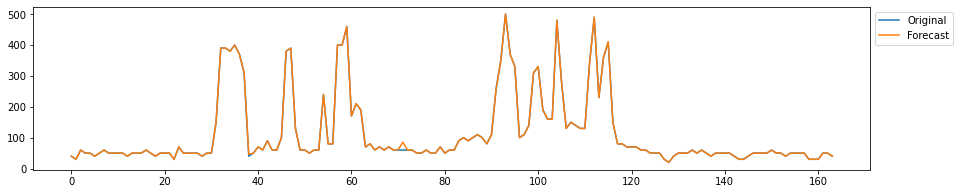

--------------------
training window 657
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2703
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2202
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1662
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1170
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0881
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0666
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0599
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0560
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0550
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0500
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0492
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0484
Epoch 13

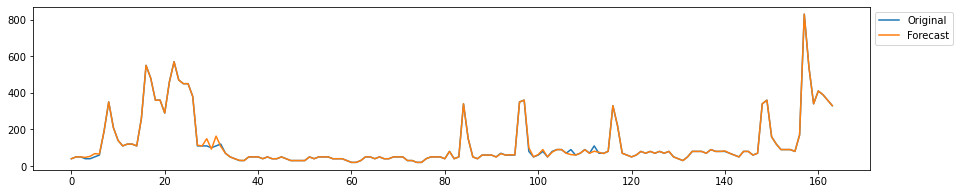

--------------------
training window 1314
Epoch 1/50
16/16 [==============================] - 0s 994us/step - loss: 0.3123
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2685
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2121
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1720
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1342
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1067
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0887
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0792
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0730
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0670
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0655
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0632
Epoch

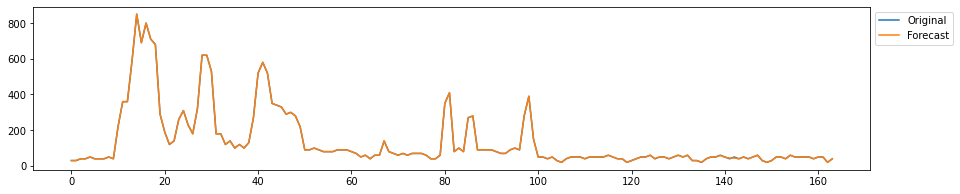

--------------------
training window 1971
Epoch 1/50
16/16 [==============================] - 0s 889us/step - loss: 0.3361
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2724
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2236
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1733
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1333
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1026
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0827
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0686
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0613
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0574
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0543
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0518
Epoch

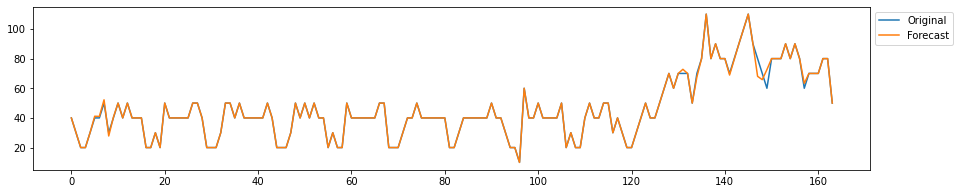

--------------------
training window 2628
Epoch 1/50
16/16 [==============================] - 0s 856us/step - loss: 0.3373
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2862
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2428
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1965
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1523
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1157
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0931
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0762
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0639
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0577
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0527
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0499
Epoch

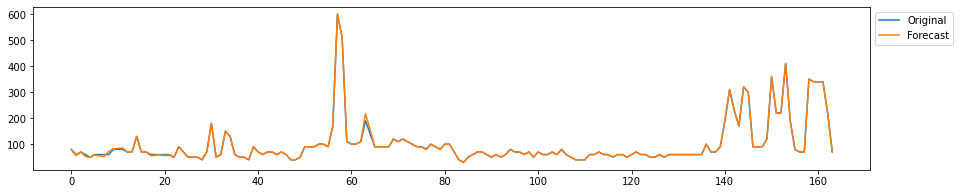

--------------------
training window 3285
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.3076
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2482
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2026
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1575
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1178
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0865
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0694
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0598
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0546
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0539
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0540
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0517
Epoch 1

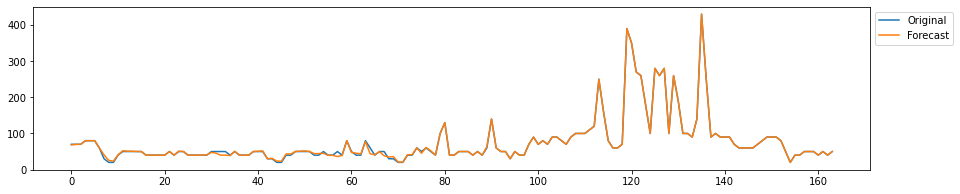

--------------------
training window 3942
Epoch 1/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2937
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2089
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1653
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1302
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1036
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0853
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0724
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0649
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0603
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0570
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0560
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0553
Epoch 1

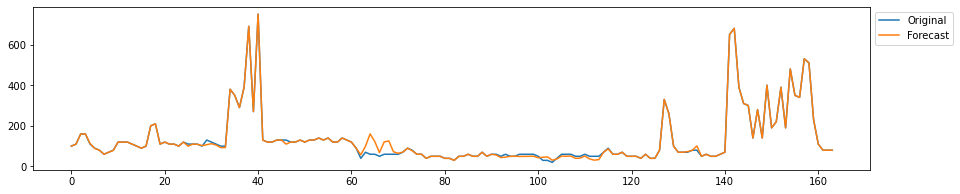

--------------------
training window 4599
Epoch 1/50
16/16 [==============================] - 0s 879us/step - loss: 0.2968
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2396
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1925
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1522
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1149
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0901
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0736
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0514
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0507
Epoch

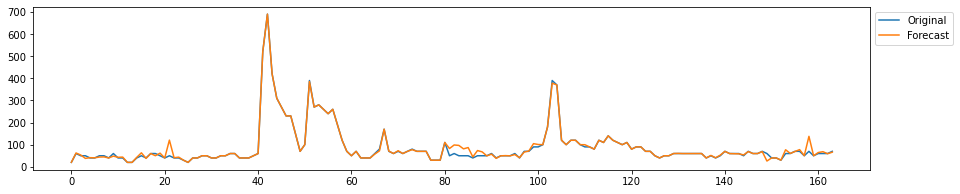

--------------------
training window 5256
Epoch 1/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2007
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1559
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1094
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0811
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0653
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0559
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0510
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0491
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0457
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0456
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0444
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0441
Epoch 1

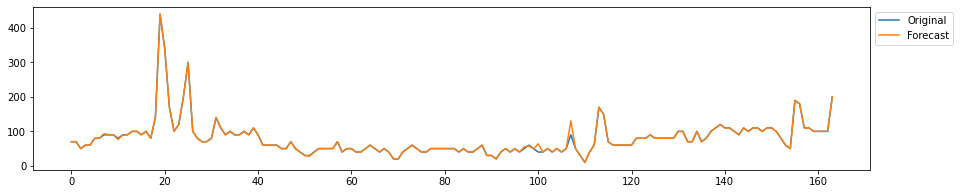

--------------------
training window 5913
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.3379
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2724
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2545
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2211
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1806
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1439
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1004
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0721
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0552
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0466
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0426
Epoch 12/50
16/16 [==============================] - 0s 4ms/step - loss: 0.0379
Epoch 1

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 00:05:35] getting statistics


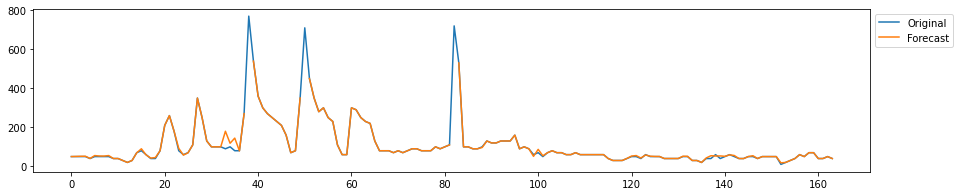

--------------------
training window 6570
Epoch 1/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2234
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1759
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1375
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1105
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0866
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0729
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0620
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0518
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0497
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0495
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0449
Epoch 1

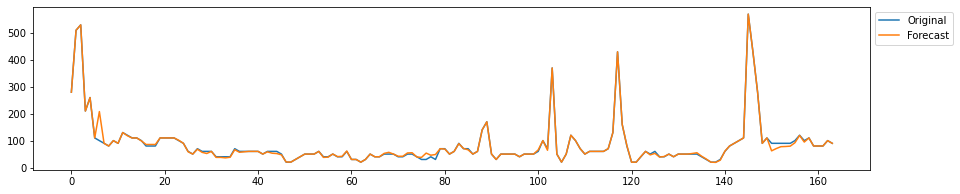

--------------------
training window 7227
Epoch 1/50
16/16 [==============================] - 0s 913us/step - loss: 0.2872
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2426
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2125
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1800
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1466
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1173
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0950
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0797
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0686
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0626
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0585
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0538
Epoch

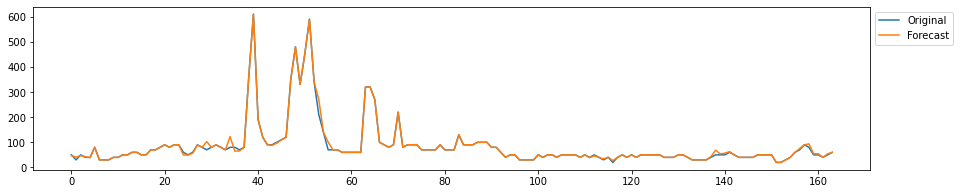

--------------------
training window 7884
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2378
Epoch 2/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1930
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1568
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1238
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0971
Epoch 6/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0785
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0669
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0620
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0570
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0544
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0507
Epoch 1

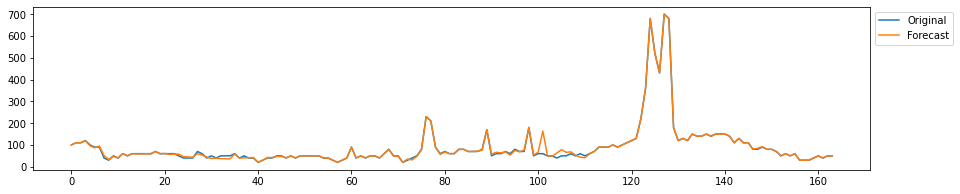

--------------------
training window 8541
Epoch 1/50
16/16 [==============================] - 0s 952us/step - loss: 0.2820
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2159
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1538
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1136
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0852
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0734
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0666
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0654
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0625
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0620
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0618
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0632
Epoch

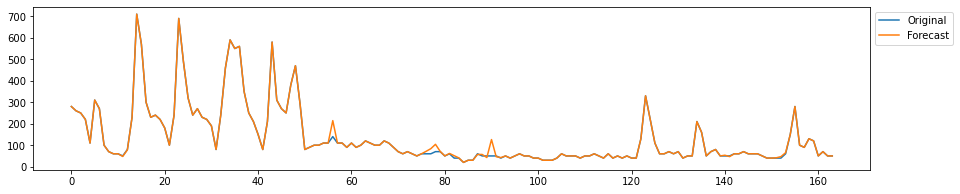

--------------------
training window 9198
Epoch 1/50
16/16 [==============================] - 1s 939us/step - loss: 0.2544
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2086
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1650
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1339
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1065
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0874
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0777
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0686
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0648
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0635
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0596
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0585
Epoch

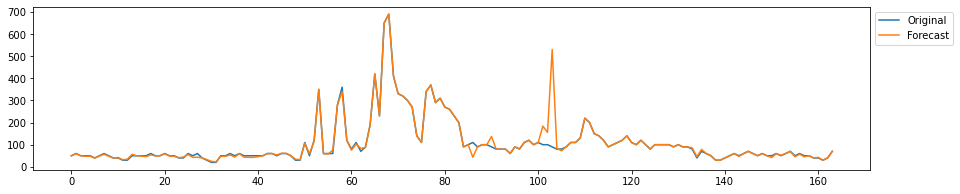

--------------------
training window 9855
Epoch 1/50
16/16 [==============================] - 0s 981us/step - loss: 0.3046
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2350
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2011
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1558
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1182
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0881
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0723
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0648
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0614
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0607
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0587
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch

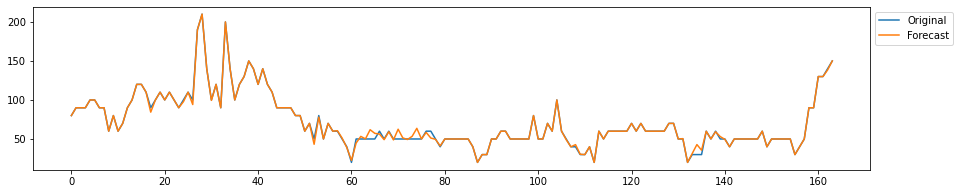

--------------------
training window 10512
Epoch 1/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2759
Epoch 2/50
16/16 [==============================] - 0s 3ms/step - loss: 0.2249
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1658
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1194
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0939
Epoch 6/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0733
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0639
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0581
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0558
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 12/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0543
Epoch 

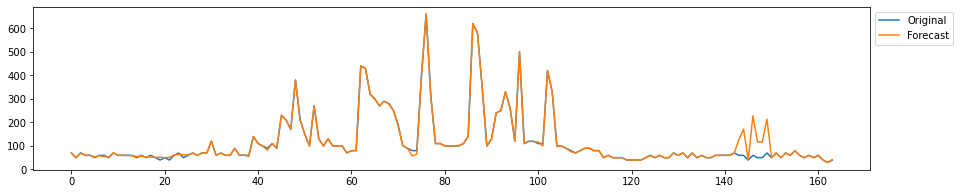

--------------------
training window 11169
Epoch 1/50
16/16 [==============================] - 0s 954us/step - loss: 0.3146
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2576
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2343
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2108
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1776
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1416
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1065
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0810
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0649
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0567
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0535
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0498
Epoc

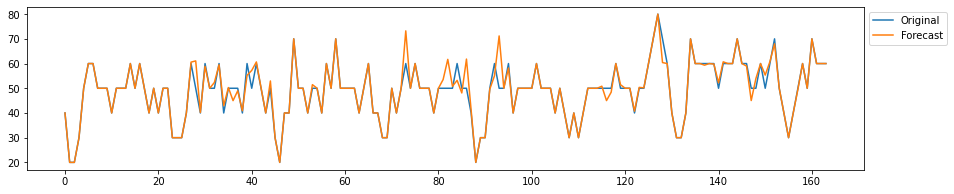

--------------------
training window 11826
Epoch 1/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2753
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2293
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1831
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1423
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1090
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0840
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0616
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0577
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0522
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0517
Epoch 

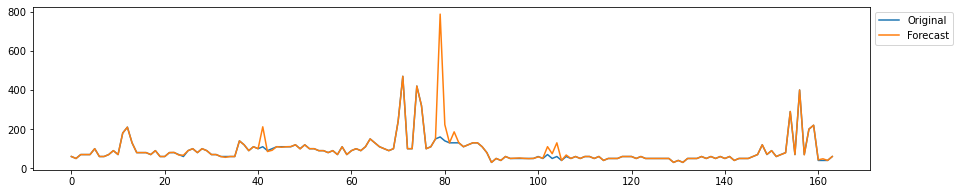

--------------------
training window 12483
Epoch 1/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2561
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2277
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1976
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1616
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1281
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0972
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0770
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0614
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0548
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0483
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0466
Epoch 

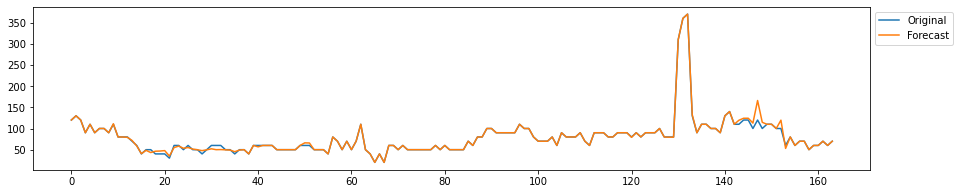

--------------------
training window 13140
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2367
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1860
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1388
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1033
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0825
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0679
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0575
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0528
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0490
Epoch 11/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0472
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0472
Epoch 

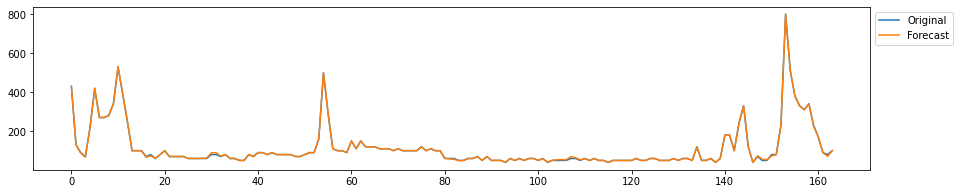

--------------------
training window 13797
Epoch 1/50
16/16 [==============================] - 0s 959us/step - loss: 0.2279
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1773
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1460
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1137
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0897
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0733
Epoch 7/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0640
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0578
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0548
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0536
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0517
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0508
Epoc

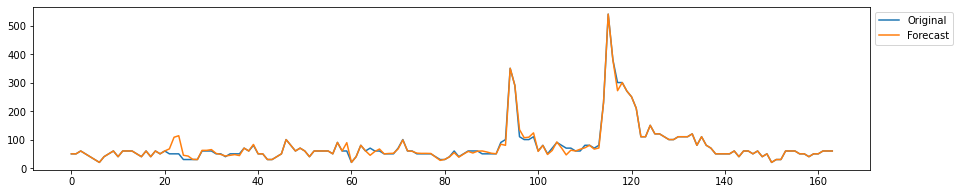

--------------------
training window 14454
Epoch 1/50
16/16 [==============================] - 0s 895us/step - loss: 0.2830
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2270
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1767
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1381
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1077
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0864
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0727
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0644
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0578
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0543
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0494
Epoc

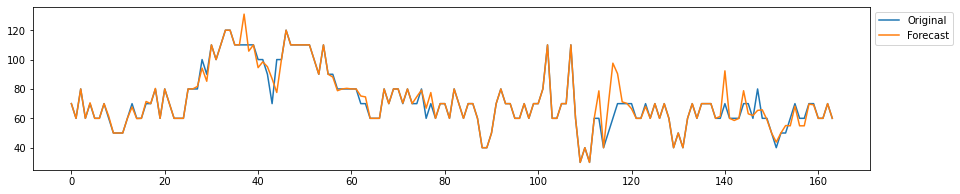

--------------------
training window 15111
Epoch 1/50
16/16 [==============================] - 1s 928us/step - loss: 0.2733
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2002
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1432
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1005
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0747
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0609
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0520
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0500
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0487
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0467
Epoch 12/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0454
Epoc

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 00:06:30] getting statistics


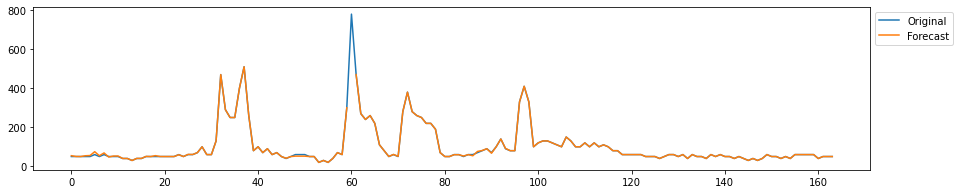

--------------------
training window 15768
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2774
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2222
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1782
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1380
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0998
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0777
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0668
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0587
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0561
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0540
Epoch 

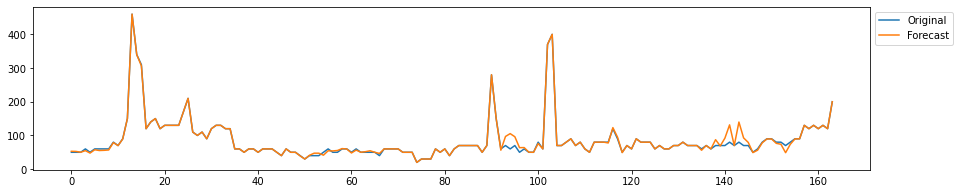

--------------------
training window 16425
Epoch 1/50
16/16 [==============================] - 0s 944us/step - loss: 0.3595
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.3017
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2672
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.2193
Epoch 5/50
16/16 [==============================] - 0s 2ms/step - loss: 0.1540
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1106
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0852
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0717
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0693
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0651
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0643
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0621
Epoc

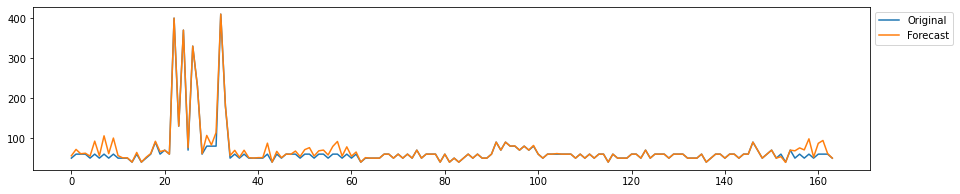

--------------------
training window 17082
Epoch 1/50
16/16 [==============================] - 1s 973us/step - loss: 0.2902
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2127
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1588
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1202
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0940
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0750
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0578
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0524
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0463
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0431
Epoc

/home/hugo/anaconda3/lib/python3.8/site-packages/pyFTS/models/multivariate/mvfts.py:165: RuntimeWarning: invalid value encountered in double_scalars
  ret.append(np.dot(mv,mp.T)/np.nansum(mv))


[ 00:06:41] getting statistics


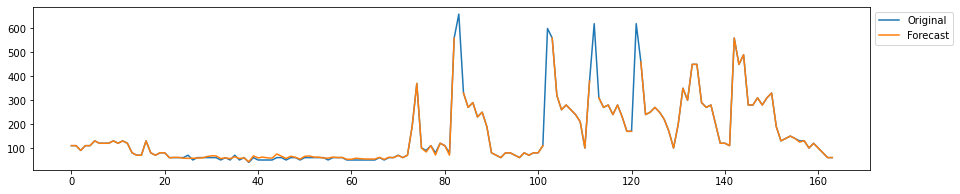

--------------------
training window 17739
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2949
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2627
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2251
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1762
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1214
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0871
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0677
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0592
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 0.0553
Epoch 11/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0536
Epoch 12/50
16/16 [==============================] - 0s 3ms/step - loss: 0.0510
Epoch 

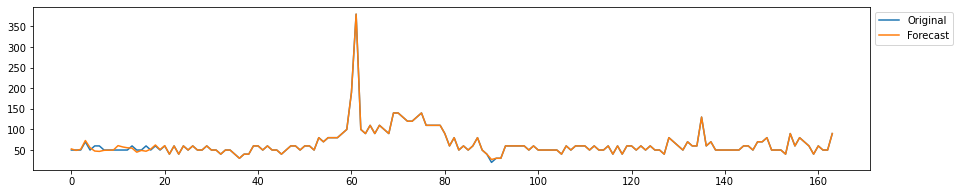

--------------------
training window 18396
Epoch 1/50
16/16 [==============================] - 1s 862us/step - loss: 0.2671
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2567
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2147
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1707
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1272
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0999
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0823
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0738
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0664
Epoch 10/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0624
Epoch 11/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0605
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0565
Epoc

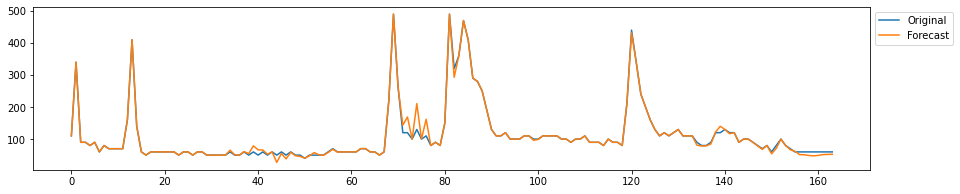

--------------------
training window 19053
Epoch 1/50
16/16 [==============================] - 1s 1ms/step - loss: 0.2832
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.2236
Epoch 3/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1832
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.1425
Epoch 5/50
16/16 [==============================] - 0s 993us/step - loss: 0.1107
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0896
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0758
Epoch 8/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0657
Epoch 9/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0608
Epoch 10/50
16/16 [==============================] - 0s 968us/step - loss: 0.0569
Epoch 11/50
16/16 [==============================] - 0s 984us/step - loss: 0.0520
Epoch 12/50
16/16 [==============================] - 0s 1ms/step - loss: 0.0519


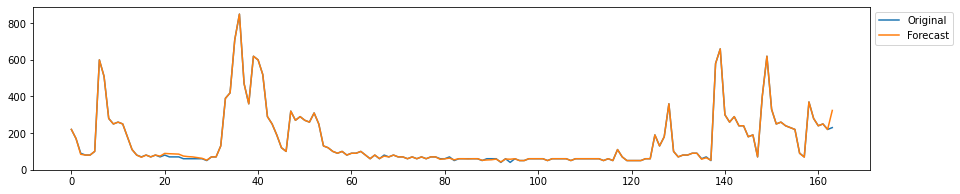

In [21]:
#Variables
# endog = data['Appliances']
# exog = data.loc[:,'lights':'Tdewpoint']
#forecasts = []
#appliances = []
result = {
     "window": [],
     "rmse": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        appliance = ttest['Appliances'].reset_index()
        appliance_train = ttrain['Appliances'].reset_index()
        print('-' * 20)
        print(f'training window {(ct)}')
        # Faz o treinamento 
        fts_model, encoder_model, encoded_train = train_reducted(ttrain.loc[:,'lights':'Tdewpoint'], appliance_train, 50)
        # Faz o teste 
        forecast, encoded_test = forecast_reducted(fts_model, encoder_model,ttest.loc[:,'lights':'Tdewpoint'],appliance)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        appliance.pop('index')
        rmse = Measures.rmse(encoded_test['Appliances'],forecast)
        mape = Measures.mape(encoded_test['Appliances'],forecast)
        smape = Measures.smape(encoded_test['Appliances'],forecast)
        
        #forecasts.append(forecast)
        #appliances.append(appliance)
        
        result["rmse"].append(rmse)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(encoded_test['Appliances'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()

measures = pd.DataFrame(result)



In [22]:
measures

,window,rmse,mape,smape
0,0,2.050605,0.374548,0.160967
1,657,6.705636,2.035954,0.955255
2,1314,0.556267,0.175035,0.088554
3,1971,1.474364,0.458929,0.227495
4,2628,2.900615,0.783316,0.389163
5,3285,2.775980,2.684445,1.337257
6,3942,13.067709,7.556787,3.166375
7,4599,11.242452,6.910878,2.891260
8,5256,3.722530,0.847226,0.356056
9,5913,9.320251,3.612240,1.499722


In [23]:
print("Mean: ")
print(statistics.mean(measures['rmse']))
print(statistics.mean(measures['mape']))
print(statistics.mean(measures['smape']))

Mean: 
8.949062429224513
3.297643388001685
1.3850680272803628
